In [1]:
import h5py
from sklearn import metrics
import numpy as np
import matplotlib.pyplot as plt
import os
import csv

In [6]:
# Load in the Dataset
predictions_dir = "../output/positive_evaulation/"
yground = np.load(predictions_dir + "labels.npy")
ylogits = np.load(predictions_dir + "pred_results.npy")
print(f'There are {yground.shape[0]} positive samples being tested.')
num_samples = yground.shape[0]

There are 26157 positive samples being tested.


In [7]:
print(np.count_nonzero(yground == 0)) # num poised
print(np.count_nonzero(yground == 2)) # num active 

15722
10435


In [8]:
## Dictionary Store for FPR Thresholds 
## Load this from Eval Results JSON file. 
POISED_THRESHOLDS = {
    0.10 : -0.39354804158210754,
    0.05 : 0.0886303037405014,
    0.03 : 0.34452739357948303,
    0.01 : 0.8528411388397217,
}

ACTIVE_THRESHOLDS = {
    0.10 : -0.5178720355033875,
    0.05 : -0.11259077489376068,
    0.03 : 0.170790046453475952,
    0.01 : 0.7585378885269165,
}

def predict(logits, fpr):
    assert fpr in [0.10, 0.05, 0.03, 0.01]

    pe_thresh = POISED_THRESHOLDS[fpr]
    ae_thresh = ACTIVE_THRESHOLDS[fpr]
    if logits[0] > pe_thresh and logits[2] > ae_thresh:
        return 0 if logits[0] > logits[2] else 2
    elif logits[0] > pe_thresh:
        return 0
    elif logits[2] > ae_thresh:
        return 2
    else:
        return 1

In [28]:
# First Print Out Overall Accuracy
fpr = 0.05
ypreds = np.apply_along_axis(predict, 1, ylogits, fpr)
usable_ypreds = np.where(ypreds != 1)[0]

fpr_thresh_acc = np.count_nonzero(ypreds == yground) / len(yground)
print(f'Accuracy accounting for FPR: {fpr_thresh_acc}')

valid_pred = ypreds != 0

Accuracy accounting for FPR: 0.5541919944947815
7595


In [23]:
# Plot Function Based on Logits - should see clustering. 
def scale(logits):
    norm = np.linalg.norm(logits, 1)
    return logits / norm

def plot_enhancer(logits, bin_width, enhancer_type, normalized):
    assert enhancer_type in ["Active", "Poised"]

    # Define sampls to bin and count
    bins = np.arange(np.min(logits), np.max(logits), bin_width)
    bin_counts, _ = np.histogram(logits, bins=bins)

    plt.bar(bins[:-1], bin_counts, width=bin_width, align='edge', alpha=0.4, color='blue')
    plt.plot(bins[:-1] + bin_width/2, bin_counts, color='blue')

    # cumulative = np.cumsum(bin_counts)
    # cumul_norm = (cumulative / cumulative[-1]) * max(bin_counts)
    # plt.plot(bins[:-1] + bin_width/2, cumul_norm, color='red')

    plt.xlabel('Acitve Enhancer Score')
    plt.ylabel(f'Number of {enhancer_type} Enhancers')
    if normalized:
        plt.title(f'Normalized Active Enhancer Score versus Number of {enhancer_type} Enhancers')
    else:
        plt.title(f'Unnormalized Active Enhancer Score versus Number of {enhancer_type} Enhancers')
    plt.show()

In [29]:
active_indices = np.where(yground == 2)
active_logits = ylogits[active_indices]
plot_enhancer(active_logits[:,2], 0.025, "Active", False)

active_normed = np.apply_along_axis(scale, 1, np.delete(active_logits, 1, axis=1))
plot_enhancer(active_normed[:,1], 0.025, "Active", True)

ValueError: The truth value of an array with more than one element is ambiguous. Use a.any() or a.all()

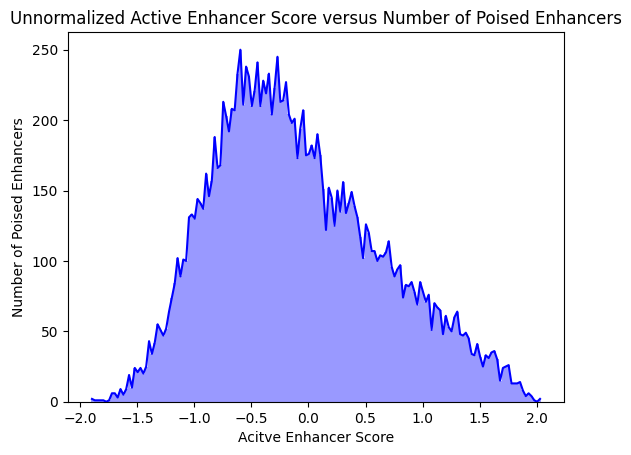

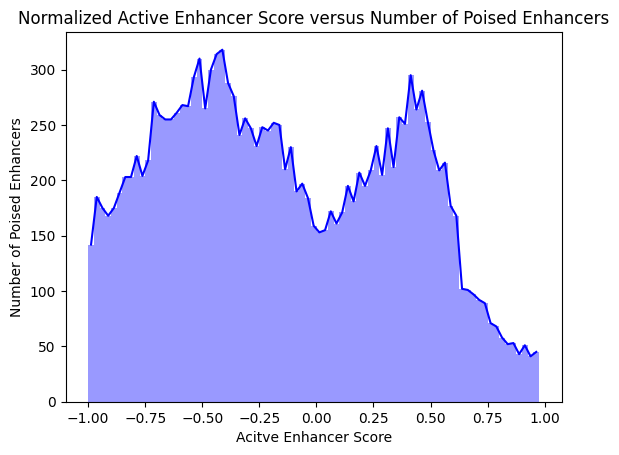

In [25]:
poised_indices = np.where(yground == 0)
poised_logits = ylogits[poised_indices]
plot_enhancer(poised_logits[:,2], 0.025, "Poised", False)

poised_normed = np.apply_along_axis(scale, 1, np.delete(poised_logits, 1, axis=1))
plot_enhancer(poised_normed[:,1], 0.025, "Poised", True)

In [15]:
import pandas as pd
from pybedtools import BedTool

bed_file = "../data/EFO-0003042.TFbinding.bed"
tf_sites = list(BedTool(bed_file))

print(tf_sites[0:2])


[Interval(chr1:180593-181003), Interval(chr1:180694-180954)]


Loading in all of the Transcription Factor Binding Sites that We Have in a BED File

In [40]:
tfsites = []
with open(bed_file, 'r') as file:
    for line in file:
        info = line.split()
        tfsites.append(info)

df_tfsites = pd.DataFrame(tfsites, columns=['Chrom', 'Start', 'End', 'TF'])

In [27]:
from pybedtools import BedTool

positive_bed = "../data/positive.bed"
positive_list = list(BedTool(positive_bed))

print(ypreds)

[0 0 0 ... 2 0 2]


In [10]:
normalized_logits = np.apply_along_axis(scale, 1, np.delete(ylogits, 1, axis=1))
active = []
poised = []
p_to_a = []

active_threshold = 0.35

for norm_logits, true_label, interval in zip(normalized_logits, yground, positive_list):
    if true_label == 2:
        active.append(interval)
    elif true_label == 0:
        if norm_logits[1] > active_threshold:
            p_to_a.append(interval)
        else: 
            poised.append(interval)

active_bed = BedTool(active)
poised_bed = BedTool(poised)
p_to_a_bed = BedTool(p_to_a)

# ae = active_bed.saveas('../data/active.bed')
# pe = poised_bed.saveas('../data/poised.bed')
# pa = p_to_a_bed.saveas('../data/p_to_a.bed')

assert((len(active) + len(poised) + len(p_to_a)) == yground.shape[0])

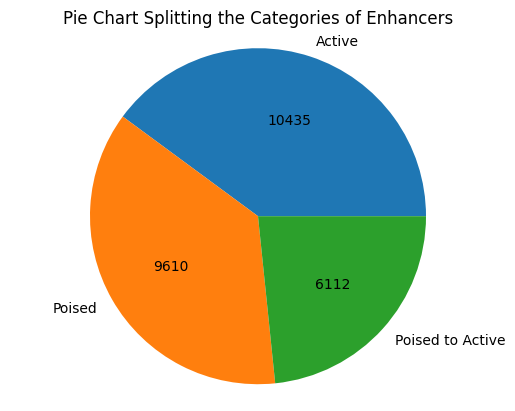

In [77]:
num_active = len(active)
num_poised = len(poised)
num_p_to_a = len(p_to_a)

import matplotlib.pyplot as plt

# Data for the three groups
group_names = ['Active', 'Poised', 'Poised to Active']
group_counts = [num_active, num_poised, num_p_to_a]

# Color blind accessible color scheme
colors = ['#1f77b4', '#ff7f0e', '#8c564b']

# Create the pie chart
fig, ax = plt.subplots()
# pie = ax.pie(group_counts, labels=group_names, colors=colors, startangle=90, autopct='%1.1f%%')

def autopct_format(values):
    def my_format(pct):
        total = sum(values)
        val = int(round(pct*total/100.0))
        return '{v:d}'.format(v=val)
    return my_format
plt.pie(group_counts, labels = group_names, autopct = autopct_format(group_counts))

# Add a title
ax.set_title('Pie Chart Splitting the Categories of Enhancers')

# Create a legend
# ax.legend(pie[0], group_names, loc='upper right')

# Equal aspect ratio ensures that pie is drawn as a circle
ax.axis('equal')

# Display the chart
plt.show()

In [85]:
print(num_active, num_poised, num_p_to_a)
sizes = {'Active' : num_active, 'Poised' : num_poised, 'PoisedtoActive' : num_p_to_a}

10435 9610 6112


In [99]:
## Read in BED Intersect Files
def read_bed(file):
    sites = []
    with open(file, 'r') as file:
        for line in file:
            info = line.split()
            sites.append(info)
    return sites

tfactive = read_bed("analysis_files/tfactive.bed")
tfpoised = read_bed("analysis_files/tfpoised.bed")
tfp_to_a = read_bed("analysis_files/tfp_to_a.bed")

print(len(tfactive), len(tfpoised), len(tfp_to_a))

117783 59824 35318


In [101]:
def process_intersection(bedlist : list):
    total_intersections = len(bedlist)
    tf_map = {}
    for bed in bedlist:
        tf = bed[3]
        if tf not in tf_map:
            tf_map[tf] = 1
        else:
            tf_map[tf] += 1
    return tf_map, total_intersections

def determine_fold_change(base, experimental, base_name, exp_name):
    tsv = f'base_{base_name}_exp_{exp_name}_FC.tsv'
    tsv_content = "tf\tbase_occur\texp_occur\tfoldchange\n"
    fold_map = {}

    num_b = sizes[base_name]
    num_e = sizes[exp_name]

    all_tfs = list(experimental.keys()) + list(base.keys())
    for tf in all_tfs:
        if tf in base and tf in experimental:
            b_occur = base[tf]
            e_occur = experimental[tf]
            fold_change = (e_occur / num_e) / (b_occur / num_b)
            tsv_content += f"{tf}\t{b_occur}\t{e_occur}\t{fold_change}\n"
            fold_map[tf] = fold_change
        elif tf in base and tf not in experimental:
            b_occur = base[tf]
            e_occur = 0
            fold_change = "nan"
            tsv_content += f"{tf}\t{b_occur}\t{e_occur}\t{fold_change}\n"
        elif tf not in base and tf in experimental:
            b_occur = 0
            e_occur = experimental[tf]
            fold_change = "nan"
            tsv_content += f"{tf}\t{b_occur}\t{e_occur}\t{fold_change}\n"
    
    with open(tsv, 'w') as tsv_file:
        tsv_file.write(tsv_content)
    return fold_map

def plot_histogram(fold_map, base, experimental):
    # Sort the dictionary by fold change values
    sorted_tf_fold_changes = sorted(fold_map.items(), key=lambda x: x[1])

    # Separate positive and negative fold changes
    positive_fold_changes = [fc for fc in fold_map.values() if fc > 0]
    negative_fold_changes = [fc for fc in fold_map.values() if fc < 0]

    # Calculate mean and standard deviation for positive fold changes
    positive_mean = np.mean(positive_fold_changes)
    positive_std = np.std(positive_fold_changes)

    # Exclude positive fold change values more than three standard deviations away from the mean
    excluded_positive_tfs = [(tf, fc) for tf, fc in fold_map.items() if fc > 0 and fc > positive_mean + 100 * positive_std]

    # Calculate mean and standard deviation for negative fold changes
    negative_mean = np.mean(negative_fold_changes)
    negative_std = np.std(negative_fold_changes)

    # Exclude negative fold change values more than three standard deviations away from the mean
    excluded_negative_tfs = [(tf, fc) for tf, fc in fold_map.items() if fc < 0 and fc < negative_mean - 100 * negative_std]

    # Combine the excluded TFs and their fold changes
    excluded_tfs = excluded_positive_tfs + excluded_negative_tfs

    # Remove the excluded TFs from the original dictionary
    for tf, fc in excluded_tfs:
        print(f"Excluded TF: {tf}, Fold Change: {fc}")
        del fold_map[tf]

    # Sort the remaining TFs by their fold change values
    sorted_tf_fold_changes = sorted(fold_map.items(), key=lambda x: x[1])
    sorted_tf_fold_changes.reverse()

    # Extract TF names and fold changes
    tf_names = [tf[0] for tf in sorted_tf_fold_changes]
    fold_changes = [tf[1] for tf in sorted_tf_fold_changes]

    # Define colors for positive and negative fold changes
    colors = ['red' if fc < 0 else 'blue' for fc in fold_changes]

    # Create the bar plot
    plt.figure(figsize=(12, 6))  # Adjust the figure size as needed
    plt.bar(tf_names, fold_changes, color=colors)
    plt.xticks(rotation=45, ha='right', fontsize=8)  # Rotate and align the x-axis labels
    plt.xlabel('Transcription Factor')
    plt.ylabel('Fold Change')
    plt.title(f'Transcription Factor Fold Changes {experimental} Compared to {base}')
    plt.tight_layout()  # Ensure labels fit within the figure

    # Show the plot
    plt.show()

/users/pranavmahableshwarkar/miniconda3_x86_64/envs/biolearning/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/users/pranavmahableshwarkar/miniconda3_x86_64/envs/biolearning/lib/python3.10/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/users/pranavmahableshwarkar/miniconda3_x86_64/envs/biolearning/lib/python3.10/site-packages/numpy/core/_methods.py:206: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/users/pranavmahableshwarkar/miniconda3_x86_64/envs/biolearning/lib/python3.10/site-packages/numpy/core/_methods.py:163: RuntimeWarning: invalid value encountered in divide
  arrmean = um.true_divide(arrmean, div, out=arrmean,
/users/pranavmahableshwarkar/miniconda3_x86_64/envs/biolearning/lib/python3.10/site-packages/numpy/core/_methods

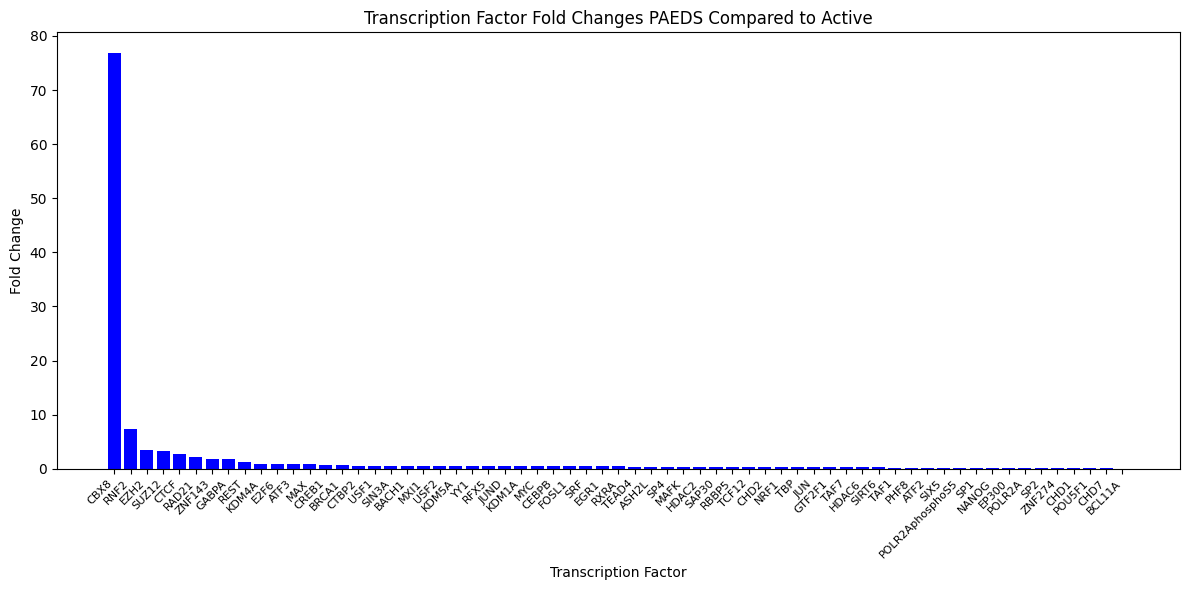

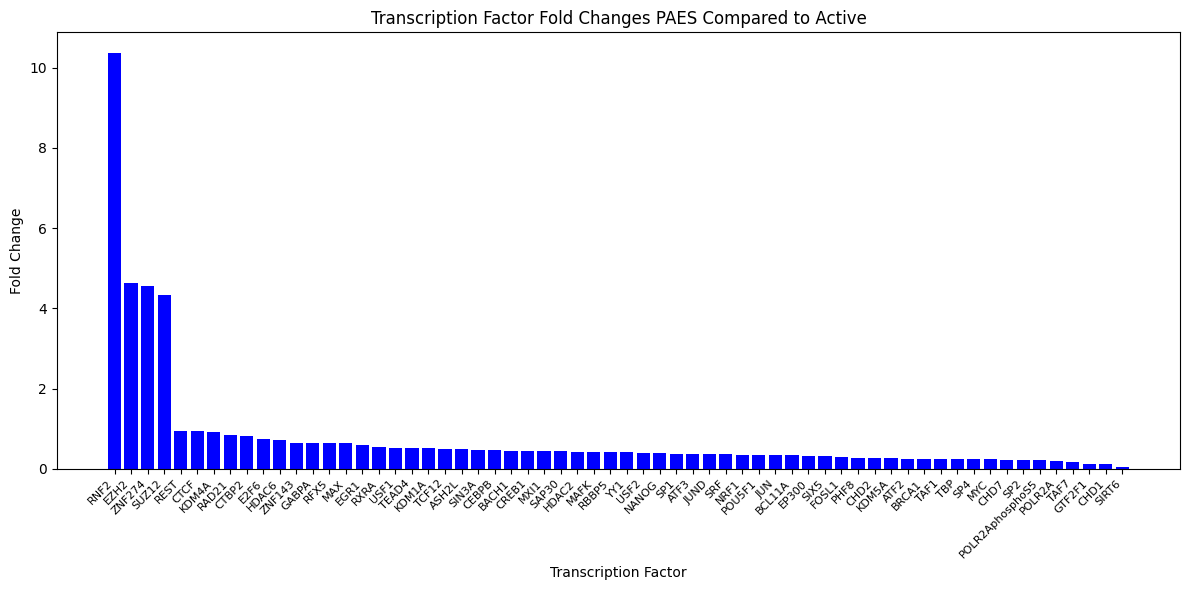

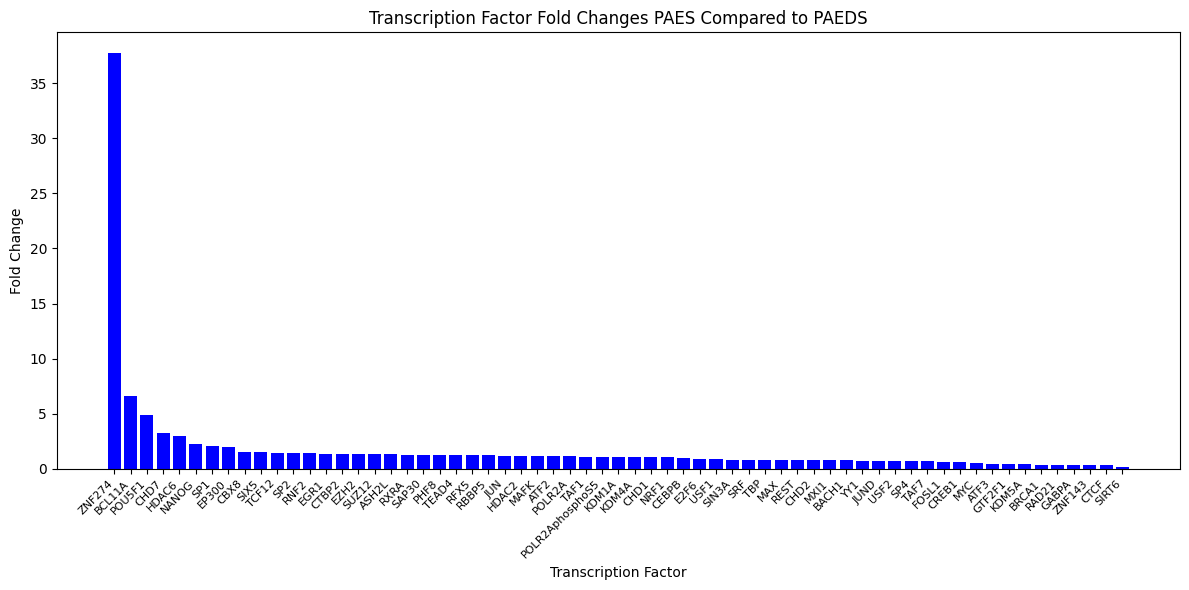

In [104]:
## Process BEDS
map_active, _ = process_intersection(tfactive)
map_poised, _ = process_intersection(tfpoised)
map_p_to_a, _ = process_intersection(tfp_to_a)

## Active vs Poised
avsp_map = determine_fold_change(map_active, map_poised, "Active", "Poised")
plot_histogram(avsp_map, "Active", "PAEDS")

## Active vs PoisedtoActive
avspa_map = determine_fold_change(map_active, map_p_to_a, "Active", "PoisedtoActive")
del avspa_map['CBX8']
plot_histogram(avspa_map, "Active", "PAES")

## Poised vs Poised_to_Active
pvspa_map = determine_fold_change(map_poised, map_p_to_a, "Poised", "PoisedtoActive")
plot_histogram(pvspa_map, "PAEDS", "PAES")

In [111]:
print(map_active['CBX8'])
print(map_poised['CBX8'])
print(map_p_to_a['CBX8'])


8
566
563
